# Sturm Liouville decomposition gives some strange results

Looking at movies produced in the vs_compare notebook, we see that there appears to be an imprint of the first mode on the higher modes. To test I'll:

 - Make a Hovmöller of each mode along the centre of the beam. Check that angles match, suggesting that yes we do have multiple modes with the same phase speed
 - Check whether the stratification changes with time in the blank case. We average temporally, but in this case the stratification might not be stable as it's spinning up from the homogenous state

In [ ]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36271 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:45829' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36271/status,
Dashboard: /proxy/36271/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45829,Workers: 7
Dashboard: /proxy/36271/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:44189,Total threads: 4
Dashboard: /proxy/43557/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36975,


2024-07-05 16:43:12,431 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:42623' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 2, 0, 4, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 4, 0, 4, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 5, 0, 4, 0), ('getitem-68f4faec78909b5c3b59b6d98695394f', 0, 0), ('rechunk-merge-694fdb03a5250bf405e16edbd5312180', 0, 8, 0, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 3, 0, 4, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 0, 0, 4, 0), ('rechunk-merge-694fdb03a5250bf405e16edbd5312180', 0, 6, 0, 0), ('rechunk-merge-ea29e6546d598498e67d75fba00bd9a0', 0, 3, 0, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 6, 0, 4, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 1, 0, 4, 0), ('rechunk-merge-89fff8b04b7ecb58c085e33915bb6561', 7, 0, 4, 0)} (stimulus_id='handle-worker-cleanup-1720161792.4304128

In [2]:
trange = 50
to_process = {
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    "ideal-20": {
        "data":tt.collect_data(
            exptname="ideal-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50))
    }
    }

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/119774815.gadi-pbs/ipykernel_3742264/2316288111.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


loading rho...	done.
loading u...	done.
loading v...	done.


In [151]:


def phiApprox(N,H,nmodes = 5):
    """
    Calculate SL approx solution only
    
    """
    print(H)
    H = N.zl.sel(zl = H,method = "ffill")
    N = N.sel(zl = slice(0,H + 0.001))
    zl = N.zl.values

    # data["N"] = np.linspace(data.N[0],data.N[-1],len(data["N"]))
    ## Later we need to do a cumulative integral along the z axis. This is a pain in xarray, so we'll use scipy and pass this to xarray's 'apply_along_axis' method. 
    def scipy_integrate(data):
        full_integral = scipy.integrate.trapezoid(data,x = zl)
        return (data * 0) + full_integral - scipy.integrate.cumulative_trapezoid(
            data,
            x = zl,
            initial = 0
            )


    # Use np.apply_along_axis to prevent averaging over N and H!
    eigenvectors = (N * 0).expand_dims({"mode":nmodes}).copy()

    Nbar = N.integrate("zl") / H
    for n in range(1,nmodes + 1): ## Start from 1 or else your first eigenfunction only depends on N!
        
        to_integrate = (n * N * np.pi) / (H * Nbar) ## This is the bit in the Approx Sturm-Liouville eqn under the integral sign within the cos term
        # This next line is a convuluted (but computationally efficient!) way of doing the cumulative sum along the z axis.
        integrated =  np.apply_along_axis(scipy_integrate,to_integrate.get_axis_num('zl'),to_integrate) 

        # This is just the rest of the eigenfunction. Fill NANs with 0s so that integrating over bathymetry doesn't cause problems.
        phi_n = (np.sqrt(
            2 * N / (H * Nbar)
        ) * np.cos(
            integrated
        )).fillna(0)

        eigenvectors[n-1,:] = phi_n
        # Handle the 3D or 3D data inputs.


    return xr.merge([eigenvectors.rename("phi")])

def HEigenfunctionError(phi,N,H,i):
    "Calculates error in LHS of horizontal eigenvalue problem"
    return (N**(-2)).differentiate("zl") * phi.isel(mode = i).differentiate("zl") + phi.isel(mode = i)*  N**2 * (i + 1)**2 * np.pi**2 / H**2
# Nfull = tt.calculate_N(to_process["full-20"]["data"].rho.mean("time").sel(yb = 0,xb = 800))
# Nideal = tt.calculate_N(to_process["ideal-20"]["data"].rho.mean("time").sel(yb = 0,xb = 800))


Hfull = -1 * to_process["full-20"]["data"].bathy.sel(xb = slice(200,1200),yb = slice(-40,40)).mean("xb").mean("yb").values

print(Hfull)
Hideal = 5000
vmodesfull = phiApprox(Nfull,Hfull,nmodes = 5)
vmodesIdeal = phiApprox(Nideal,Hideal,nmodes = 5)
# vmodesFull = newVerticalModes(to_process["full-20"]["data"],smoothing = False,ML_cutoff=0).load()

4453.598961689922
4453.598961689922
5000


## Compare N profiles 

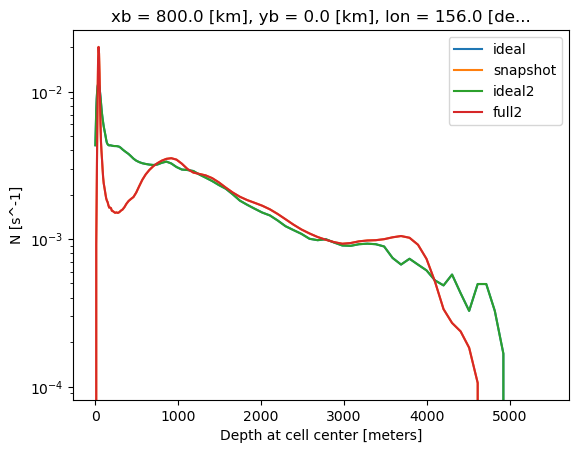

In [38]:
# to_process["ideal-20"]["data"].N.mean("xb").mean("yb").plot(label = "ideal")
to_process["ideal-20"]["data"].N.sel(xb = 800,yb = 0,method = "nearest").plot(label = "ideal")
to_process["full-20"]["data"].N.sel(xb = 800,yb = 0,method = "nearest").plot(label = "snapshot")
Nideal.plot(label = "ideal2")
Nfull.plot(label = "full2")
plt.yscale("log")
plt.legend()

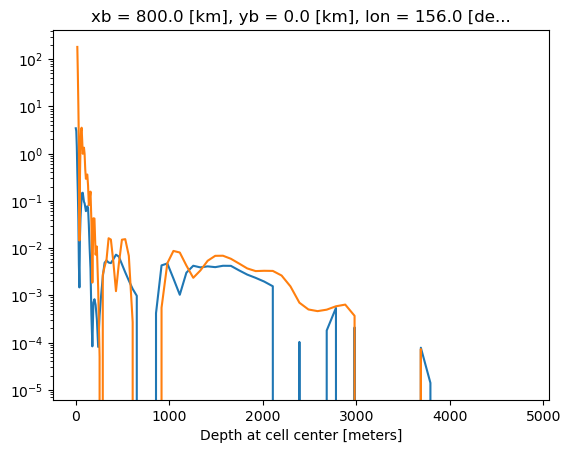

In [55]:
HEigenfunctionError(vmodesIdeal.phi,
                    Nideal,
                    Hideal,
                    0).plot(yscale = "log")
HEigenfunctionError(vmodesfull.phi,
                    Nfull,
                    Hfull,
                    0).plot(yscale = "log")

## Try smoothing N with polynomial and then apply regular SL approx

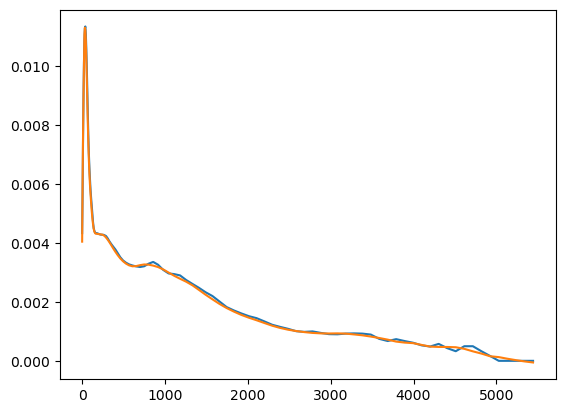

In [154]:
plt.plot(Nideal.zl,Nideal)
plt.plot(NIsmooth.zl,NIsmooth)

In [80]:
def filterN(N,window_length = 20,polyorder = 5):
    return xr.DataArray(
        savgol_filter(N.values, window_length, polyorder),
        coords = {"zl":N.zl},
        dims = ["zl"]
    )

In [116]:
NIsmooth = filterN(Nideal.sel(zl = slice(0,Hideal)), 10, 5)
NIsmooth.shape

(95,)

5000


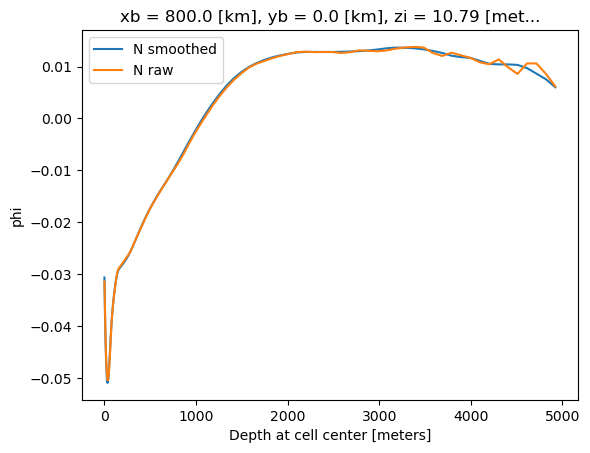

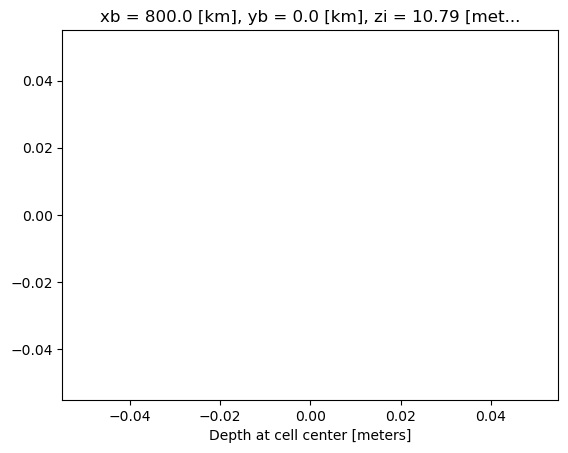

In [153]:

NIsmooth = filterN(Nideal, 10, 2)
phiIsmooth = phiApprox(NIsmooth,Hideal,nmodes = 5)
phiIsmooth.phi.isel(mode = 0).plot(label = "N smoothed")
vmodesIdeal.phi.sel(zl = slice(0,Hideal)).isel(mode = 0).plot(label = "N raw")
plt.legend()
plt.figure()
HEigenfunctionError(phiIsmooth.phi,NIsmooth,Hideal,0).plot()
HEigenfunctionError(vmodesIdeal.phi,
                    Nideal,
                    Hideal,
                    0).isel(zl = slice(0,Hideal)).plot()

## Test on linear N??

5000
5000


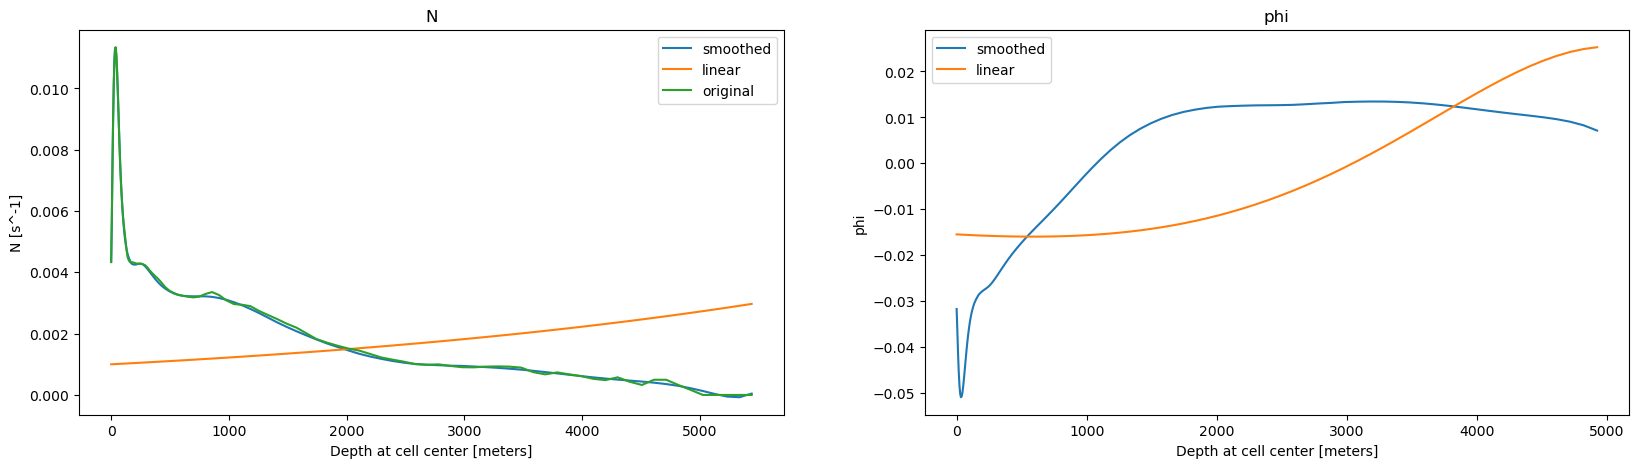

2024-07-05 16:43:12,910 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker.py", line 1252, in heartbeat
    response = await retry_operation(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 452, in retry_operation
    return await retry(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/utils_comm.py", line 431, in retry


In [180]:
fig,ax = plt.subplots(1,2,figsize = (20,5))

Nlinear = xr.DataArray(
    0.001 * np.exp(Nideal.zl / 5000),
    dims = ["zl"],
    coords = {"zl":Nideal.zl}
)
# Nlinear[:] = 0.01
NIsmooth = filterN(Nideal, 50, 10)

NIsmooth.plot(ax = ax[0],label = "smoothed")
Nlinear.plot(ax = ax[0],label = "linear")
Nideal.plot(ax = ax[0],label = "original")


phiIsmooth = phiApprox(NIsmooth,Hideal,nmodes = 5)
philinear = phiApprox(Nlinear,Hideal,nmodes = 5)
phiIsmooth.phi.isel(mode = 0).plot(ax = ax[1],label = "smoothed")

philinear.phi.isel(mode = 0).plot(ax = ax[1],label = "linear")
ax[0].set_title("N")
ax[1].set_title("phi")
ax[0].legend()
ax[1].legend()

## Make a numerical ODE solver for vertical eigenfunction:

$ \huge \frac{d^2}{dz^2} \frac{1}{N^2} \phi_n + \lambda_n^2 \phi_n $

where 

$ \huge \lambda_n = \frac{N(z) \pi n}{H} $

First recast into first order system"

\

$ \huge w(x,y,z,t) = W(z) e^{i(xk_1 + yk_2 - \omega t)} $

$ \huge \partial_{zz} W(z) + k_{n}^{2} \left(\frac{N(z)^{2}}{\omega^2 - f^2} \right) W(z) = 0$